In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from fancyimpute import BiScaler , SoftImpute
import copy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

a) How many songs are in the training dataset? How many users? Based on the training set, provide summary statistics (mean, median, standard deviation, min, and max) for the rating variable.

In [60]:
#loading the datasets
train_data = pd.read_csv("MusicRatingsTrain.csv")
val_data_A = pd.read_csv("MusicRatingsValidationA.csv")
val_data_B = pd.read_csv("MusicRatingsValidationB.csv")
test_data = pd.read_csv("MusicRatingsTest.csv")


In [61]:
#visualizing the structure of the data
train_data.head()

,userID,songID,rating,songName,year,artist,genre
0,778,242,1.494918,Billy Liar,2003,The Decemberists,Rock
1,1892,673,2.149164,The Big Gundown,2009,The Prodigy,Electronic
2,2403,452,1.494918,Hummer,2007,Foals,Rock
3,1376,437,1.494918,October Song,2003,Amy Winehouse,RnB
4,1479,192,1.494918,Far Away (Album Version),2006,Nickelback,Rock


In [62]:
#counting the nb of songs and users in the training dataset
nb_songs = len(train_data["songID"].unique())
nb_users = len(train_data["userID"].unique())
print("There are: ", nb_songs, "songs in the training dataset. \n There are ", nb_users, "users in the training dataset.")

There are:  807 songs in the training dataset. 
 There are  2421 users in the training dataset.


In [63]:
#statistics on the ratings 
train_data["rating"].describe()

count    245997.000000
mean          1.322631
std           0.460886
min           1.000000
25%           1.000000
50%           1.000000
75%           1.494918
max           4.768656
Name: rating, dtype: float64

b) Let X denote the “true” and “complete” ratings matrix, i.e., $X_{i,j}$ denotes the expected rating 
of user i for song j across all users and all songs. We are interested in predicting the values of $X_{i,j}$
that correspond to cases where we have not yet observed ratings. Let us first consider the following model:
$$X_{i,j} = \alpha _i + β_j + ϵ_{i,j}$$
where $α_i$ is a coefficient that depends only on the particular row i (i.e., user), $β_j$ is a coefficient
that depends only on the particular column j (i.e., song), and $ϵ_{i,j}$ is a noise term.

### i)

In [64]:
#computing the number of parameters

nb_params = int(nb_songs) * int(nb_users)
print("There are: ", nb_params, "parameters in the model considered.")

There are:  1953747 parameters in the model considered.


In [65]:
#computing the number of observations 

nb_obs = len(train_data)
print("There are: ", nb_obs, "observation to train the model considered.")

There are:  245997 observation to train the model considered.


In [66]:
#creating the rating matrices
train_data_pivot = train_data.pivot_table(index='userID', columns='songID', values='rating')
train_data_array = train_data_pivot.to_numpy()

train_data_mask = ~np.isnan(train_data_array)
n_missing_values = np.sum(train_data_mask==False)
print(f"\nNumber of missing values in the training dataset: {n_missing_values}")


Number of missing values in the training dataset: 1707750


In [67]:
#fitting the Biscaler 
biscaler = BiScaler()
train_data_centered = biscaler.fit_transform(train_data_array)


[BiScaler] Initial log residual value = 9.840515
[BiScaler] Iter 1: log residual = 2.093693, log improvement ratio=7.746821
[BiScaler] Iter 2: log residual = 0.473543, log improvement ratio=1.620150
[BiScaler] Iter 3: log residual = -0.418028, log improvement ratio=0.891571
[BiScaler] Iter 4: log residual = -1.204926, log improvement ratio=0.786898
[BiScaler] Iter 5: log residual = -1.940070, log improvement ratio=0.735144
[BiScaler] Iter 6: log residual = -2.639589, log improvement ratio=0.699519
[BiScaler] Iter 7: log residual = -3.314790, log improvement ratio=0.675201
[BiScaler] Iter 8: log residual = -3.973003, log improvement ratio=0.658213
[BiScaler] Iter 9: log residual = -4.618484, log improvement ratio=0.645481
[BiScaler] Iter 10: log residual = -5.253418, log improvement ratio=0.634934
[BiScaler] Iter 11: log residual = -5.878700, log improvement ratio=0.625282
[BiScaler] Iter 12: log residual = -6.494471, log improvement ratio=0.615771
[BiScaler] Iter 13: log residual = -7.

In [68]:
#creating matrices
train_data_centered_zero = copy.copy(train_data_centered)
train_data_centered_zero[np.isnan(train_data_centered_zero)] = 0
train_data_filled = biscaler.inverse_transform(train_data_centered_zero)

### ii)

In [69]:
#plotting the top 3 songs and 3 artists 
top_songs = np.argpartition(biscaler.column_means, -3)[-3:][::-1]
songs = [train_data[train_data.songID ==song]['songName'].iloc[0] for song in top_songs]
artists = [train_data[train_data.songID ==song]['artist'].iloc[0] for song in top_songs]
top_songs_artists = pd.DataFrame({
    'songID': top_songs,
    'songName': [train_data[train_data.songID == song]['songName'].iloc[0] for song in top_songs],
    'artist': [train_data[train_data.songID == song]['artist'].iloc[0] for song in top_songs],
    'mean_rating': biscaler.column_means[top_songs]
}, index = ["top1", "top2", "top3"])

top_songs_artists

,songID,songName,artist,mean_rating
top1,53,Korg Rhythm Afro,Holy Fuck,2.166508
top2,25,Seven Nation Army,The White Stripes,2.130272
top3,438,Stay Where You Are,Sleater-kinney,2.040191


### iii)

In [70]:
# plotting top 3 users
top_users = np.argpartition(biscaler.column_means, -3)[-3:][::-1]
table_top_users = pd.DataFrame(columns=['userID', 'mean_rating'], data={'userID': top_users, 'mean_rating': biscaler.row_means[top_users]}, index=['Top 1', 'Top 2', 'Top 3'])
table_top_users


,userID,mean_rating
Top 1,53,-0.035934
Top 2,25,0.122080
Top 3,438,-0.116710


### iv)

In [71]:
#plotting the metrics 

def calculate_masked_mae(true_values, predicted_values, mask):
    masked_diff = true_values[mask] - predicted_values[mask]
    return np.mean(np.abs(masked_diff))

def calculate_masked_mse(true_values, predicted_values, mask):
    masked_diff = true_values[mask] - predicted_values[mask]
    return np.mean(masked_diff ** 2)

def calculate_OSR2(model_mse, baseline_mse):
    return 1 - model_mse / baseline_mse

test_pivot = test_data.pivot_table(index="userID", columns = "songID", values = "rating", dropna=False)
test_pivot = pd.merge(pd.Series(train_data_pivot.index),test_pivot.reset_index(),how='outer',on='userID').set_index('userID')
test_matrix = test_pivot.to_numpy()

test_matrix_mask =  ~np.isnan(test_matrix)
np.sum(test_matrix_mask)
test_matrix_mask.shape, test_matrix.shape

((2421, 807), (2421, 807))

In [72]:
#creating the matrices
mat_centered_0 = copy.copy(train_data_centered)
mat_centered_0[np.isnan(mat_centered_0)]=0
matrx_filled = biscaler.inverse_transform(mat_centered_0)

matrx_filled = biscaler.inverse_transform(mat_centered_0)
matrx_filled.shape

(2421, 807)

In [73]:
test_mae = calculate_masked_mae(test_matrix, matrx_filled, test_matrix_mask)
print("Biscale MAE %s " % (test_mae)) 

test_mse = calculate_masked_mse(test_matrix, matrx_filled, test_matrix_mask)
print("Biscale RMSE %s " % (np.sqrt(test_mse)))

print("Biscale normalized MAE %s " % (test_mae/4)) #Note that we normalize MAE and RMSE by the scale of the ratings, which is 5-(1)=4.
print("Biscale normalized RMSE %s " % (np.sqrt(test_mse)/4))

baseline_pred = np.mean(train_data.rating)
baseline_model = baseline_pred*np.ones((nb_users, nb_songs))
baseline_mse = calculate_masked_mse(test_matrix, baseline_model,test_matrix_mask)
print("Biscale R2 %s" % calculate_OSR2(test_mse, baseline_mse))

Biscale MAE 0.29868140372347 
Biscale RMSE 0.39300653381998196 
Biscale normalized MAE 0.0746703509308675 
Biscale normalized RMSE 0.09825163345499549 
Biscale R2 0.28718485726354515


### c) i)

In [74]:
#computing the number of parameters
print("There are k*", str(nb_songs+nb_users), '+', nb_params, "parameters in this new model. \nThe exact number depends on k.")
print("We still have", nb_obs, "observations to train this model")

There are k* 3228 + 1953747 parameters in this new model. 
The exact number depends on k.
We still have 245997 observations to train this model


### ii)

In [75]:
val_data_A_pivot = val_data_A.pivot_table(index="userID", columns="songID", values="rating", dropna=False)
val_data_A_pivot = pd.merge(pd.Series(train_data_pivot.index), val_data_A_pivot.reset_index(), how='outer', on='userID').set_index('userID')
val_mat_A = val_data_A_pivot.values
val_mat_A_mask = ~np.isnan(val_mat_A)
np.sum(val_mat_A_mask)

14470

In [76]:
cv_mae = []
for i in range(20):
    param_cv = i + 1
    soft_imputer_cv = SoftImpute(max_rank=param_cv, verbose=False)
    filled_centered_mat_cv = soft_imputer_cv.fit_transform(train_data_centered)
    filled_mat_cv = biscaler.inverse_transform(filled_centered_mat_cv)
    filled_mat_cv = np.clip(filled_mat_cv, 1, 5)
    val_mae_cv = calculate_masked_mae(val_mat_A, filled_mat_cv, val_mat_A_mask)
    cv_mae.append(val_mae_cv)
    print('iter %s - Validation MAE %s' % (param_cv, val_mae_cv))


iter 1 - Validation MAE 0.2886936722736267
iter 2 - Validation MAE 0.28647784501862783
iter 3 - Validation MAE 0.28475858028767437
iter 4 - Validation MAE 0.281602817007934
iter 5 - Validation MAE 0.2819492455522867
iter 6 - Validation MAE 0.2822331823592897
iter 7 - Validation MAE 0.2822882939793443
iter 8 - Validation MAE 0.28401391540358845
iter 9 - Validation MAE 0.283926355676094
iter 10 - Validation MAE 0.28592292185779267
iter 11 - Validation MAE 0.28806453176663366
iter 12 - Validation MAE 0.28647460705301986
iter 13 - Validation MAE 0.2899378106903881
iter 14 - Validation MAE 0.29170007448660057
iter 15 - Validation MAE 0.29148619153565936
iter 16 - Validation MAE 0.2920103456528623
iter 17 - Validation MAE 0.2943806037227161
iter 18 - Validation MAE 0.2954273917147392
iter 19 - Validation MAE 0.29956652444751014
iter 20 - Validation MAE 0.30130243615166097


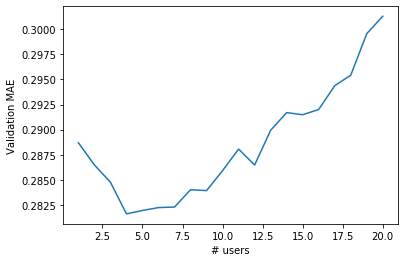

In [77]:
plt.plot(range(1,21), cv_mae)
plt.xlabel('# users')
plt.ylabel('Validation MAE')
plt.show()

The value of k (number of users) that minimizes the MAE on the validation set A is 6.
### iii)

In [78]:
#building the final model witht the right value of k
soft_imputer = SoftImpute(max_rank=6, verbose=True)
soft_imputer_filled = soft_imputer.fit_transform(train_data_centered)
test_soft_imputer_filled = biscaler.inverse_transform(soft_imputer_filled)
test_soft_imputer_filled = np.clip(test_soft_imputer_filled, 1, 5)

[SoftImpute] Max Singular Value of X_init = 62.587108
[SoftImpute] Iter 1: observed MAE=0.770978 rank=6
[SoftImpute] Iter 2: observed MAE=0.757046 rank=6
[SoftImpute] Iter 3: observed MAE=0.748145 rank=6
[SoftImpute] Iter 4: observed MAE=0.742283 rank=6
[SoftImpute] Iter 5: observed MAE=0.737416 rank=6
[SoftImpute] Iter 6: observed MAE=0.733654 rank=6
[SoftImpute] Iter 7: observed MAE=0.730600 rank=6
[SoftImpute] Iter 8: observed MAE=0.728018 rank=6
[SoftImpute] Iter 9: observed MAE=0.725793 rank=6
[SoftImpute] Iter 10: observed MAE=0.723939 rank=6
[SoftImpute] Iter 11: observed MAE=0.722218 rank=6
[SoftImpute] Iter 12: observed MAE=0.720764 rank=6
[SoftImpute] Iter 13: observed MAE=0.719451 rank=6
[SoftImpute] Iter 14: observed MAE=0.718342 rank=6
[SoftImpute] Iter 15: observed MAE=0.717273 rank=6
[SoftImpute] Iter 16: observed MAE=0.716386 rank=6
[SoftImpute] Iter 17: observed MAE=0.715568 rank=6
[SoftImpute] Iter 18: observed MAE=0.714818 rank=6
[SoftImpute] Iter 19: observed MAE=0.

In [79]:
mae_softimpute = calculate_masked_mae(test_matrix, test_soft_imputer_filled, test_matrix_mask)
print("The SoftImpute MAE is: ", mae_softimpute)

mse_softimpute = calculate_masked_mse(test_matrix, test_soft_imputer_filled, test_matrix_mask)
print("The SoftImpute RMSE is: ", np.sqrt(mse_softimpute))

normalized_mae_softimpute = mae_softimpute/4
print("The SoftImpute normalized MAE is: ", normalized_mae_softimpute)

normalized_rmse_softimpute = np.sqrt(mse_softimpute)/4
print("The SoftImpute normalized RMSE is: ", normalized_rmse_softimpute)

baseline_prediction = np.mean(train_data.rating)
baseline_model = baseline_prediction*np.ones((nb_users, nb_songs))
baseline_mse = calculate_masked_mse(test_matrix, baseline_model, test_matrix_mask)
print("The SoftImpute R2 is: ", calculate_OSR2(model_mse=mse_softimpute, baseline_mse=baseline_mse))


The SoftImpute MAE is:  0.28281460544961295
The SoftImpute RMSE is:  0.38656501371828306
The SoftImpute normalized MAE is:  0.07070365136240324
The SoftImpute normalized RMSE is:  0.09664125342957076
The SoftImpute R2 is:  0.31035996288799916


### d) i)

In [80]:
#creating the independent features
unique_genre = list(train_data['genre'].unique())
unique_year = list(train_data['year'].unique())
unique_year.sort()

In [81]:
#creating the train and test datasets to perform the task on 

train_X = pd.DataFrame()
test_X = pd.DataFrame()

for g in range(len(unique_genre)-1):
    train_X['genre'+str(g+1)] = train_data['genre'].apply(lambda x : 1 if x == unique_genre[g] else 0)
    test_X['genre'+str(g+1)] = test_data['genre'].apply(lambda x : 1 if x == unique_genre[g] else 0)

for y in range(len(unique_year)-1):
    train_X['year'+str(y+1)] = train_data['year'].apply(lambda x : 1 if x == unique_year[y] else 0)
    test_X['year'+str(y+1)] = test_data['year'].apply(lambda x : 1 if x == unique_year[y] else 0)

In [82]:
train_X

,genre1,genre2,genre3,genre4,genre5,genre6,year1,year2,year3,year4,...,year18,year19,year20,year21,year22,year23,year24,year25,year26,year27
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245992,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
245993,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
245994,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
245995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# defining the target

train_y = train_data['rating']
test_y = test_data['rating']

In [84]:
#importing the models 

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [86]:
# performing Grid Search to find the optimal ccp alpha

param_grid = {'ccp_alpha': np.linspace(0, 0.01, 75)}
tree_reg = DecisionTreeRegressor(random_state=2)
grid_search = GridSearchCV(tree_reg, param_grid=param_grid, cv=10).fit(train_X, train_y)


In [90]:
best_alpha = grid_search.best_params_['ccp_alpha']
mean_scores = grid_search.cv_results_['mean_test_score']
best_alpha.shape, mean_scores.shape

((), (75,))

In [91]:
# Fit and predict with model 1
model1 = DecisionTreeRegressor(random_state=42)
model1.fit(train_X, train_y)
y_pred_1 = model1.predict(test_X)
test_mae1 = mean_absolute_error(test_y, y_pred_1)
test_rmse1 = mean_squared_error(test_y, y_pred_1, squared=False)
test_r2_1 = r2_score(test_y, y_pred_1)

In [92]:
# Fit and predict with model 2
model2 = LinearRegression()
model2.fit(train_X, train_y)
y_pred_2 = model2.predict(test_X)
test_mae2 = mean_absolute_error(test_y, y_pred_2)
test_rmse2 = mean_squared_error(test_y, y_pred_2, squared=False)
test_r2_2 = r2_score(test_y, y_pred_2)

In [93]:
# Create a table with the results
results = pd.DataFrame({
    'Model': ['Model 1', 'Model 2'],
    'MAE': [test_mae1, test_mae2],
    'RMSE': [test_rmse1, test_rmse2],
    'Normalized MAE': [test_mae1/4, test_mae2/4],
    'Normalized RMSE': [test_rmse1/4, test_rmse2/4],
    'OSR2': [test_r2_1, test_r2_2]
})

# Print the table
print(results.to_string(index=False))

  Model      MAE     RMSE  Normalized MAE  Normalized RMSE     OSR2
Model 1 0.368092 0.455405        0.092023         0.113851 0.042862
Model 2 0.371157 0.458016        0.092789         0.114504 0.031852


### d) ii) 

In [94]:
# creating the dataframes 

val_B_X = pd.DataFrame()
for g in range(len(unique_genre)-1):
    val_B_X['genre'+str(g+1)] = val_data_B['genre'].apply(lambda x : 1 if x == unique_genre[g] else 0)

for y in range(len(unique_year)-1):
    val_B_X['year'+str(y+1)] = val_data_B['year'].apply(lambda x : 1 if x == unique_year[y] else 0)


In [95]:
# predicting with the trained models 

pred_B_1_y = model1.predict(val_B_X)
pred_B_2_y = model2.predict(val_B_X)

In [96]:
#fitting the Soft Imputer

val_B_pivot = val_data_B.pivot_table(index="userID", columns = "songID", values = "rating", dropna=False)
val_B_pivot = pd.merge(pd.Series(train_data_pivot.index),val_B_pivot.reset_index(),how='outer',on='userID').set_index('userID')
matrix_val_B = val_B_pivot.to_numpy()
matrix_val_B_mask =  ~np.isnan(matrix_val_B)


mat_B_centered_filled = soft_imputer.fit_transform(train_data_centered)
val_B_soft_imputer_filled = biscaler.inverse_transform(mat_B_centered_filled)
val_B_soft_imputer_filled = np.clip(test_soft_imputer_filled, 1, 5)

[SoftImpute] Max Singular Value of X_init = 62.587030
[SoftImpute] Iter 1: observed MAE=0.770594 rank=6
[SoftImpute] Iter 2: observed MAE=0.756299 rank=6
[SoftImpute] Iter 3: observed MAE=0.748058 rank=6
[SoftImpute] Iter 4: observed MAE=0.741980 rank=6
[SoftImpute] Iter 5: observed MAE=0.737155 rank=6
[SoftImpute] Iter 6: observed MAE=0.733282 rank=6
[SoftImpute] Iter 7: observed MAE=0.730110 rank=6
[SoftImpute] Iter 8: observed MAE=0.727480 rank=6
[SoftImpute] Iter 9: observed MAE=0.725215 rank=6
[SoftImpute] Iter 10: observed MAE=0.723249 rank=6
[SoftImpute] Iter 11: observed MAE=0.721563 rank=6
[SoftImpute] Iter 12: observed MAE=0.720066 rank=6
[SoftImpute] Iter 13: observed MAE=0.718758 rank=6
[SoftImpute] Iter 14: observed MAE=0.717550 rank=6
[SoftImpute] Iter 15: observed MAE=0.716548 rank=6
[SoftImpute] Iter 16: observed MAE=0.715662 rank=6
[SoftImpute] Iter 17: observed MAE=0.714871 rank=6
[SoftImpute] Iter 18: observed MAE=0.714153 rank=6
[SoftImpute] Iter 19: observed MAE=0.

In [97]:
# computing the predicted ratings for val B dataset

y_coll_filter_B = []

for i in range(len(val_data_B)):
    user , song = val_data_B['userID'].iloc[i]-1 , val_data_B['songID'].iloc[i]-1
    y_coll_filter_B.append(val_B_soft_imputer_filled[user,song])

y_coll_filter_B = pd.Series(y_coll_filter_B)

In [98]:
# Construct the predictor and target variables
X = pd.DataFrame({
    'Regression Tree': pred_B_1_y,
    'Linear Regression': pred_B_2_y,
    'Collaborative Filtering': y_coll_filter_B
})
y = val_data_B['rating']


In [99]:
# Fit the OLS regression model
model = sm.OLS(y, X).fit()


In [100]:
# Print the model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 rating   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                          6.014e+04
Date:                Sun, 23 Apr 2023   Prob (F-statistic):                        0.00
Time:                        21:35:02   Log-Likelihood:                         -6559.3
No. Observations:               14471   AIC:                                  1.312e+04
Df Residuals:                   14468   BIC:                                  1.315e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [101]:
# prediciting outcomes for both models for coll filtering

y_test_1 = model1.predict(test_X)
y_test_2 = model2.predict(test_X)
y_coll_filter = []

In [102]:
# defining collaborative filtering series

for i in range(len(test_data)):
    user , song = test_data['userID'].iloc[i]-1 , test_data['songID'].iloc[i]-1
    y_coll_filter.append(test_soft_imputer_filled[user,song])

y_coll_filter = pd.Series(y_coll_filter)

In [103]:
#predicitng results for blended model

X = pd.DataFrame(
    {'Regression Tree': y_test_1, 
    'Linear Regression': y_test_2, 
    'Collaborative Filtering': y_coll_filter})

y_test = test_data['rating']
y_blended = model.predict(X)

In [104]:
# defining metrics for each model

models =  ['Regression Tree','Linear Regression','Collaborative Filtering','Blended']
metrics = ['Normalized RMSE','Normalized MAE','OSR2']

RMSE = [test_rmse1/4, test_rmse2/4, mean_squared_error(y_test, y_coll_filter, squared=False)/4, mean_squared_error(y_test, y_blended, squared=False)/4]
MAE = [test_mae1/4, test_mae2/4,mean_absolute_error(y_test, y_coll_filter)/4, mean_absolute_error(y_test, y_blended)/4]
OSR2 = [test_r2_1, test_r2_2, r2_score(y_test, y_coll_filter), r2_score(y_test, y_blended)]

In [105]:
#print the results 

table = pd.DataFrame(columns = metrics ,data={'Normalized RMSE' :RMSE,'Normalized MAE' :MAE , 'OSR2' :OSR2},index=models)
table

,Normalized RMSE,Normalized MAE,OSR2
Regression Tree,0.113851,0.092023,0.042862
Linear Regression,0.114504,0.092789,0.031852
Collaborative Filtering,0.096641,0.070704,0.310356
Blended,0.095779,0.072535,0.322614
